In this notebook, we will take a look how svm can be coded from scratch. I felt sometimes it can be useful to view everything in one notebook for instance the loss function, cost compute, gradients explaination. So we will try to cover here.

I will not be going in detail what is SVM and why SVM. For that I recommend to revisit Prof. Lecture to get clear explaination on it.


#### Topic Covered
- Theory on cost function
- Loss function gradient compute
- SGD training with dataloader
- Model Testing
- Generating confusion matrix and other performance measure metrices
- Early Stopping and saving model weights

#### SVM is used for binary & multi-class classification. <br>
- It creates a line/plane/hyperplane to separate classes
- Only support vectors are useful in making those accurate decision boundary.

As shown in the image: Two classes are tagged as $$y_i = +1 / -1$$
- We need to find a decision boundary such that the gap / margin between two classes is maximum
- In formal way, we need to find a line such for given data point x if it belongs to <br>
class +1 $$w^T.x_+ + b >= 1$$
class -1 $$w^T.x_- + b <= -1$$
on decision boudary $$w^T.x + b = 0$$ 

Goal: To maximize the margin (w) between the classes<br>
Computation: Image we are on the decision boundary and moving perpendicular to +1 support vector line.
            Distance travelled: $$w^T.(x + m.\frac{\overline{w}.\overline{w}}{ \Vert{w}\Vert}) + b = 1$$ 
            $$m = \frac{1}{\Vert{w}\Vert_2^2}$$
            $$M: \frac{2}{\Vert{w}\Vert}$$
            
Instead of maximimzation problem, we minimize 1/margin.

Calculation of Margin:

Let's compile the constraint for class +1 / -1 in one equation. Denote class label as y_i
$$y_i.(w.x_i + b) >= 1$$
$$y_i.(w.x_i + b) -1 >=0$$

##### This is a constraint we need to abide while min of margin.

What does this eq tells us?<br>
- If the sample is correctly classified then the value will be greater equal to 1<br>
- If not it will be less equal to 0<br>
- The loss we will use is Hinge Loss: $$max(0,1-y_i.(w.x_i + b))$$

In case of correctly classified max(0,<0) = 0 and otherwise the penalty of second value in max. <br>
Hope you are getting the intuition. So, essentially we wanna minimize this loss as much as possible but are we forgetting something? Yes..wanna minimize margin as well.<br>
$$L_{w*,b*} = \frac{1}{2} . \Vert{w}\Vert_2^2 + \frac{1}{N} \sum_i^N \alpha_i max(0,1-y_i.(w.x_i + b))$$

Alpha is called Laplace constant which acts as regularizer.

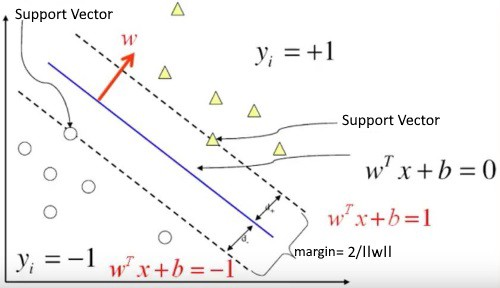

In [5]:
from IPython.display import Image
Image(filename='./svm.jpeg')

In [ ]:
# Recommended to change to coolest jupyter theme by uncommenting the commands
#-------------
#pip install jupyterthemes
#import jupyterthemes as jt
#!jt -l
# jt -t onedork
#-------------

In [291]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import random

In [358]:
class SVM:
    
    def __init__(self,alpha,lr):
    
        self.config = {
            'alpha':alpha,
            'lr':lr,
            'batch_size':64,
            'epochs':10,
            'loss_threshold':1e-4,
            'model_path':'./model_weight.npy'
        }

    def save_model(self,best_model_weights):
        
        model_path = self.config['model_path']
        np.save(model_path,best_model_weights)
        
    def compute_cost(self,X,y,W):
        
        N = X.shape[0]
        distances = 1 - y * (np.dot(X, W))
        distances[distances < 0] = 0  # equivalent to max(0, distance)
        hinge_loss = self.config['alpha'] * (np.sum(distances) / N)

        # calculate cost
        cost = 1 / 2 * np.dot(W, W) + hinge_loss
        return cost

    def dataloader(self,X,y,batch_size):
        
        '''
        In ML/DL when data size is huge, we pass the data in size/chunks
        This where dataloader comes into place. You will see dataloader in DL majorily
        '''
        
        for i in range(0,len(X),batch_size):
            x1 = X[i:i+batch_size]
            y1 = y[i:i+batch_size]
            yield(x1,y1)
    
    
    def early_stopping(self,prev_loss,curr_loss):
        
        '''
        When the loss function is not decreasing after certain epochs, that means update in weights
        will be very small. In such scenario we stop the iteration 
        '''
        
        if(abs(prev_loss-curr_loss) <= self.config['loss_threshold']):
            return True
        
        return False
    
    def grad(self,W,X,y):
        
        
        #One can take a look at the Loss eq above and derive the dL/dw for weight updates
        
        reg = self.config['alpha']
        dw = np.zeros(X.shape[1])
        dist = 1 - y * (X.dot(W))
        dist = np.where(dist < 0,0,dist)
        
        for i,d in enumerate(dist):
            
            if(d == 0):
                dl_dw = W
            
            else:
                dl_dw = W - (reg * y[i] * X[i])
                
            dw += dl_dw
            
        dw = dw / X.shape[0]
        
        return dw
    
    
    def fit(self,X,y,X_test,y_test,epochs=None,batch_size=None):
        
        '''
        Previously, we were using GD in that technique we pass whole data in one shot for training
        This has a huge problem: - Easily Overfit -Time consuming
        So SGD demands to randomly sample from given dataset and train on them. Read on why SGD widely used
        over GD. In this, I am using batch training where data is loaded into chunks. You can also take
        a chunk or chunks for training. It is not mandate to use whole data as such
        '''
        
        #initialize 
        self.costs = []
        self.weights = []
        
        #setting parameters
        self.W = np.zeros(X.shape[1])
        epochs = self.config['epochs'] if epochs is None else epochs
        batch_size = self.config['batch_size'] if batch_size is None else batch_size
        lr = self.config['lr']
        
        prev_loss = float('inf')
        severe_counter = 1
        
        for i in tqdm(range(epochs)):
            
            cost = 0
            count = 0
            
            for x_sub,y_sub in self.dataloader(X,y,batch_size):
                
                dL_dW = self.grad(self.W,x_sub,y_sub)
                self.W = self.W - lr*dL_dW
                cost += self.compute_cost(x_sub,y_sub,self.W)
                count +=1
                
            self.costs.append(cost/count)
            test_loss = self.compute_cost(X_test,y_test,self.W)
            train_acc = self.score(X,y)
            test_acc = self.score(X_test,y_test)
            
            print(f'Epoch:{i} Train Loss:{self.costs[-1]} Train acc:{train_acc}  Test loss:{test_loss} Test acc:{test_acc}')
            print(time.sleep(1))
            
            #saving weights at each epoch, this can we useful when epoch has stopped early and now you have
            #past histories weight to deduce the accuracy and losses incurred during that epoch
            self.weights.append(self.W)
            
            
            #check for early stopping by measuring loss and prev_loss
            res = self.early_stopping(prev_loss,self.costs[-1])
            
            #Uncomment to early stop the training
            '''
            if(res):
                if(severe_counter % 5 == 0):
                    print(f'--------Early Stopping Executed at epoch {i}-------------')
                    print(f'------Saving best model weights----------')
                    self.save_model(best_model_weights)
                    break
                severe_counter +=1
                
            else:
                severe_counter = 0
            
            #saving best model weights monitored on training loss
            if(self.costs[-1] < prev_loss):
                best_model_weights = self.W
                
            prev_loss = self.costs[-1]
            '''
            
    def metric(self,X,y):
        
        '''
        We will plot some metrics such as recall,precision, f1-score to get to know their importance
        '''
        
        y_pred = self.predict(X)
        true_neg = 0
        true_pos = 0
        false_pos = 0
        false_neg = 0
        
        for i in range(len(y_pred)):
            if(y_pred[i] != y[i]):
                if(y[i] == 1):
                    false_neg +=1  
                else:
                    false_pos +=1
            else:
                if(y_pred[i] == 1):
                    true_pos +=1 
                else:
                    true_neg +=1
        
        recall = true_pos / (true_pos + false_neg)
        precision = true_pos / (true_pos + false_pos)
        f1_score = 2 * (recall * precision) / (recall + precision)
        
        print(f'Recall is ',recall)
        print(f'Precision is  ',precision)
        print(f'F1 score is ',f1_score)
        
    def plot(self,arr,xlabel,ylabel):
        
        '''
        Plots Train loss vs epochs, accuracy vs epoch curves to understand how model is performing
        '''
        
        plt.plot(range(len(arr)),arr)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        
    
    def predict(self,X):
        return np.sign(np.dot(X,self.W))
        
    def score(self,X,y):
        
        correct  = 0
        y_pred = self.predict(X)
        return 100 * sum([1 if y_pred[i] == y[i] else 0 for i in range(len(y_pred)) ]) / len(y_pred)
        

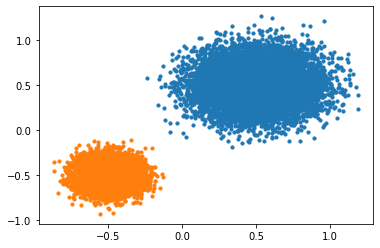

In [361]:
#Using simple cooked up data
#Feel free to play with data orientation (overlapped data and see how linear svm fails badly)

def buildData():
    
    mu = 0.5
    sigma = 0.2

    mu1 = -0.5
    sigma1 = 0.1

    x_cor = np.random.normal(mu, sigma, 10000)
    y_cor = np.random.normal(mu, sigma, 10000)

    x1_cor = np.random.normal(mu1, sigma1, 10000)
    y1_cor = np.random.normal(mu1, sigma1, 10000)

    plt.scatter(x_cor,y_cor,s=10)
    plt.scatter(x1_cor,y1_cor,s=10)
    
    X_ = pd.DataFrame()
    X_['1'] = np.array(list(x_cor) + list(x1_cor))
    X_['2'] = np.array(list(y_cor) + list(y1_cor))

    X_final = X_.to_numpy()
    y_final = np.array([1]*10000 + [-1]*10000)
    
    X,y = shuffle(X_final,y_final)
    
    return X,y

X,y = buildData()
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)


In [362]:
# Model training Routine
svc = SVM(1,0.01)
svc.fit(X_train,y_train,X_test,y_test,epochs=10,batch_size=128)


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Epoch:0 Train Loss:0.8400636799205233 Train acc:99.96875  Test loss:0.7692563881692952 Test acc:100.0


 10%|████████▎                                                                          | 1/10 [00:01<00:09,  1.08s/it]

None
Epoch:1 Train Loss:0.756615776219293 Train acc:99.96875  Test loss:0.7504144895229383 Test acc:100.0


 20%|████████████████▌                                                                  | 2/10 [00:02<00:08,  1.08s/it]

None
Epoch:2 Train Loss:0.7498253633499399 Train acc:99.96875  Test loss:0.7488493232780616 Test acc:100.0


 30%|████████████████████████▉                                                          | 3/10 [00:03<00:07,  1.08s/it]

None
Epoch:3 Train Loss:0.7492677737744978 Train acc:99.96875  Test loss:0.7487102862475725 Test acc:100.0


 40%|█████████████████████████████████▏                                                 | 4/10 [00:04<00:06,  1.08s/it]

None
Epoch:4 Train Loss:0.7492205915771628 Train acc:99.96875  Test loss:0.7486956406630582 Test acc:100.0


 40%|█████████████████████████████████▏                                                 | 4/10 [00:05<00:08,  1.35s/it]

None
--------Early Stopping Executed at epoch 4-------------
------Saving best model weights----------


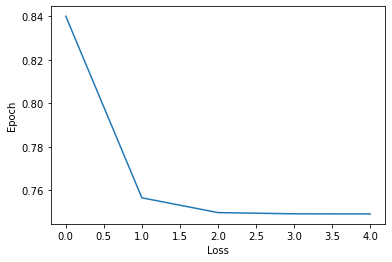

In [364]:
#Loss plot
#Since the data is highly seperable, we are convergencing in 2 epochs. Try out real world dataset
svc.plot(svc.costs,'Loss','Epoch')

In [365]:
print('Test Accuracy ',svc.score(X_test,y_test))
print('Make Prediction',svc.predict(X_test),'\n')
print('----------Metrics-------')
svc.metric(X,y)

Test Accuracy  100.0
Make Prediction [-1.  1. -1. ... -1.  1. -1.] 

----------Metrics-------
Recall is  0.9995
Precision is   1.0
F1 score is  0.9997499374843711


### Finally SVM conlcusion

- What we implemented is linear SVM, it certainly has drawback when data is not separable then it fails to find the margin and thus performance decreases
- In that we make use of kernels which transforms the input data to some other space and then finds a hyperplane
- If a decision boundary exists then SVM will definitely find it in an optimal manner
- We make use of Soft Margin instead of Hard margin given specific tolerance rate (misclassification we are willing to accept)
